### (0) IMPORT

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from spotipy.oauth2 import SpotifyClientCredentials
from bs4 import BeautifulSoup
from selenium import webdriver
from sklearn.cluster import KMeans
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from kneed import KneeLocator
import time
import spotipy
import pandas as pd

#BORROWING KAISHENGS CLIENT SECRET AND ID THANKS KS BB PLS DONT DISABLE YA
auth_manager = SpotifyClientCredentials(client_id="21ff73a9b5a94ea8b3a969b906baead1", client_secret="3761e7947ef542149467196a07cf2563")
sp = spotipy.Spotify(auth_manager=auth_manager)

### (1) FUNCTIONSSS

In [5]:
def ohe_prep(df, column, new_name): 
    ''' 
    Create One Hot Encoded features of a specific column
    ---
    Input: 
    df (pandas dataframe): Spotify Dataframe
    column (str): Column to be processed
    new_name (str): new column name to be used
        
    Output: 
    tf_df: One-hot encoded features 
    '''
    
    tf_df = pd.get_dummies(df[column])
    
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)  
    return tf_df

def get_features_database(databaseDF, feature_weights):
    #Select Features
    databaseDF = databaseDF[["id","songName",
                "danceability","energy","key","loudness","mode","speechiness","acousticness","instrumental","liveness",
                "valence","tempo","type"]]

    #OHE Features
    key_ohe = ohe_prep(databaseDF, 'key','key') * feature_weights['key']
    mode_ohe = ohe_prep(databaseDF, 'mode','mode') * feature_weights['mode']

    ##Normalise/Scale Audio Columns
    float_cols = databaseDF.dtypes[databaseDF.dtypes == 'float64'].index.values
    floats = databaseDF[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns)

    # Apply weight to each float column
    for col in floats_scaled.columns:
        floats_scaled[col] *= feature_weights.get(col, 1.0)

    ##Combine all Features
    final = pd.concat([floats_scaled, key_ohe, mode_ohe, databaseDF["type"]], axis = 1)
    return final


feature_weight = {
    "danceability": 0.6,
    "energy": 0.7,
    "key": 0.1,
    "loudness": 0.8,
    "mode": 0.1,
    "speechiness": 0.5,
    "acousticness": 0.3,
    "instrumentalness": 0.5,
    "liveness": 0.3,
    "valence": 0.7,
    "tempo": 0.6,
    "type": 0.1
}

def generate_rec(databaseDF, database_vector, user_vector, genre):
    #Cosine Similarity
    databaseDF["sim"] = cosine_similarity(database_vector,user_vector)

    #Drop rows with different genre from top 3 genres
    databaseDF = databaseDF[(databaseDF["genre"] == genre)]

    rec_top5 = databaseDF.sort_values('sim',ascending = False).head()
    return rec_top5



### (2) NORMALISING Genre Names
If METHOD1 does not work for particular song, do METHOD2 so on and so forth <br><br>
METHOD1 - Find User Songs in Dataset and Copy Over <br>
METHOD2 - Webscrap from get_genre.com which genre name is generic and similar to dataset<br>
METHOD3 - SPOTIFYAPI


In [6]:
##GENRE ENGINEERING
genre_dict = {
    "pop": ["pop punk", "pop rap", "pop rock", "synthpop","dance-pop", "singer-songwriter"],
    "rock": ["psych rock","power pop","alt rock", "hard rock","emo","blues", "folk", "garage", "pop rock", "acoustic", "rock and roll", "singer-songwriter", ""],
    "metal": ["metalcore","black metal", "death metal", "heavy metal", "goth", "gothic metal", "groove", "punk", "grindcore", "industrial", "alternative metal"],
    "house": ["chicago house", "progressive house", "deep house", "edm", "electro house", "future house", "tech house"],
    "country": ["country pop", "country blues", "country rap", "country rock"],
    "r&b": ["soul","dance","contemporary r&b", "alternative r&b", "soul jazz", "r&b and soul","rhythm and blues"],
    "techno": ["detroit techno","minimal techno", "hardcore"],
    "electro": ["drum and bass","dubstep","electronic", "club", "electro house", "electronic dance music", "electro swing", "electropop"],
    "hip hop": ["rap", "funk", "alternative hip hop", "rap rock", "rap metal", "jazz rap"],
    "k-pop": [],
    "indie": ["indie rock", "indie pop"]
}

def generaliseGenre(genre):
    for key,value in genre_dict.items():
        ##if genre scrapped is same as generic genre(key), return genre
        if key == genre:
            return key
        else:
            ##iterate through all the genres (value) in the dict to find suitable generic genre
            for alt_genre in value:
                if alt_genre == genre:
                    return key
    ##return none if no genre found
    return None

def scrap_genre(artistName):
    ##URL of website to scrap
    url = f"https://www.getgenre.com/artist/{artistName}"


    ##CHANGE PATH TO PATH OF DOWNLOADED CHROMEDRIVER
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--disable-gpu')
    driver = webdriver.Chrome(options=options)
    
    # WAIT FOR BUTTON TAG TO LOAD BEFORE CONTINUING
    driver.implicitly_wait(20)
    driver.get(url)
    
    try:
        classtext = "MuiButtonBase-root MuiButton-root MuiButton-outlined MuiButton-outlinedPrimary MuiButton-sizeMedium MuiButton-outlinedSizeMedium MuiButton-root MuiButton-outlined MuiButton-outlinedPrimary MuiButton-sizeMedium MuiButton-outlinedSizeMedium css-x3ahaf"
        button = driver.find_element(By.XPATH, '//*[@id="genres-text"]/div/button')
        time.sleep(5)
        # Parse the HTML content of the button with BS4
        html = button.get_attribute("outerHTML")
        driver.close()
        driver.quit()

        #Use BS4 to read HTML segement and extract Genre Text
        soup = BeautifulSoup(html, "html.parser")
        # Find html button tag with class to obtained genre text
        genre = soup.find('button', class_=classtext).get_text().lower()
        result = generaliseGenre(genre)
        return result
    except:
        driver.close()
        driver.quit()
        pass


In [7]:
##Import User Playlist
userDF = pd.read_csv("User_Playlist.csv")
userDF = userDF.drop(columns=["Unnamed: 0"])
##Import Dataset
df = pd.read_csv("spotify_dataset_eda.csv")
df = df.drop(columns=["Unnamed: 0"])
df = df.dropna()

#Extract all genres from dataset
datasetGenres_list = []
for i in df["genre"]:
    if i not in datasetGenres_list:
        datasetGenres_list.append(i)

song_genres_list = []

## Dict for scrapped genres to avoid scraping same artist multiple times
scrap_dict = {}

##Find Playlist Songs in Database and replace genre
for index, row in userDF.iterrows():
    id = row["id"]
    artistName = row["artist"]

    ##List to include all genres from one song
    one_song_genre = []

    ##Check if artistName is already scrapped or tracked
    if artistName in scrap_dict.keys():
        genre = scrap_dict[artistName]
        one_song_genre.append(genre)
    else:
        ##variable to check if song in database
        dataset_genre = df[df["id"] == id]

        if not dataset_genre.empty:
            ##METHOD1 - Searches for kaggle ds for song inputted to retrieve genre (matching kaggle ds). 
        ##If found, genre from kaggle ds replaces highly specific genre of song retrieved from spotify
            one_song_genre = dataset_genre["genre"].to_list()
            for i in one_song_genre:
                scrap_dict[artistName] = i
        else:
            ##METHOD2 - Web Scraping to retrieve simplified genre from getgenre.com to replace highly specific genre retrieved from spotify
            genre = scrap_genre(artistName)
            scrap_dict[artistName] = genre
            if genre != "":
                one_song_genre.append(genre)

    ##CHECKS IF METHOD 1 or 2 managed to obtain generalised genre data
    song_genres_list.append(one_song_genre)

userDF["genre"] = [genre[0] for genre in song_genres_list]
userDF = userDF.dropna(subset=["genre"])
userDF

Cache folder (C:\Users\jiowe\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\jiowe\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\jiowe\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\jiowe\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\jiowe\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\jiowe\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\jiowe\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\jiowe\.cache\selenium) cannot be created: Cannot crea

,id,songName,albumName,albumID,artist,genre,explicit,releaseDate,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumental,liveness,valence,tempo,duration_ms,time_signature
0,52eIcoLUM25zbQupAZYoFh,redrum,american dream,2RRYaYHY7fIIdvFlvgb5vq,21 Savage,hip hop,True,2024-01-12,0.624,0.740,...,-8.445,1,0.0481,0.005290,0.000224,0.5000,0.246,172.089,270698,4
1,4tqcoej1zPvwePZCzuAjJd,Wet Dreamz,2014 Forest Hills Drive,0UMMIkurRUmkruZ3KGBLtG,J. Cole,hip hop,True,2014-12-09,0.495,0.722,...,-8.108,0,0.3570,0.069700,0.000000,0.1130,0.539,175.627,239267,4
2,1SGt65i9AnXYdDQt1AtDRH,3500 (feat. Future & 2 Chainz),Rodeo,4PWBTB6NYSKQwfo79I3prg,Travis Scott,house,True,2015-09-04,0.773,0.595,...,-6.062,0,0.1610,0.114000,0.000002,0.1300,0.338,123.968,461840,4
3,6R0GRYk2vs2XuBVemYK5YZ,Ultimate,Ultimate,5r0LVuUjx659ddoV15P5MI,Denzel Curry,hip hop,True,2015-01-01,0.493,0.826,...,-3.106,1,0.3110,0.095000,0.000003,0.2520,0.750,112.865,189974,4
4,1lOe9qE0vR9zwWQAOk6CoO,Ransom,We Love You Tecca,1I6FpscJIfwf4T56VxGVsB,Lil Tecca,hip hop,True,2019-08-30,0.745,0.642,...,-6.257,0,0.2870,0.020400,0.000000,0.0658,0.226,179.974,131240,4
5,6KxSEVnd0SYtk2QiOAnMIp,Invincible Shield,Invincible Shield (Deluxe Edition),0SgF4c7VeFBoATEdpTvgG8,Judas Priest,metal,False,2024-03-08,0.544,0.966,...,-4.812,0,0.0976,0.000077,0.018400,0.2810,0.455,120.021,381068,4
6,6IMtQCeUaVg4K6pyk3LyBi,Wash It Away,Wash It Away,4WNRKcQakjSUvjbw9lVF7c,The Ghost Inside,metal,False,2024-02-05,0.515,0.876,...,-4.660,1,0.0711,0.000041,0.000027,0.4530,0.389,101.968,214710,4
7,256sFTOD01wutUbC7omH17,Sucks 2 Suck,Sucks 2 Suck,4vApNOb7B86XOY1DdLcs7w,Alpha Wolf,metal,True,2024-01-24,0.409,0.988,...,-2.476,0,0.4620,0.000294,0.002640,0.1000,0.288,199.844,233093,4
8,2GWtLHhqPjvZt1aWiBDsTU,Cellar Door,Cellar Door,5z9EQ9ABAqMmUVnOo7pDHt,Spiritbox,metal,False,2023-10-13,0.174,0.935,...,-4.362,1,0.1350,0.000159,0.427000,0.4670,0.163,84.478,283957,4
9,11EVeW30HHEMZZsWgWzdfN,Eternally Yours,Graveyard Shift,5ucBd1GYFRg0uVhP4a4AY6,Motionless In White,metal,False,2017-05-05,0.481,0.940,...,-3.288,0,0.0564,0.001130,0.000000,0.1070,0.194,94.948,312352,4


### (3) CLUSTERING choose number of clusters or auto

C:\Users\jiowe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jiowe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jiowe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

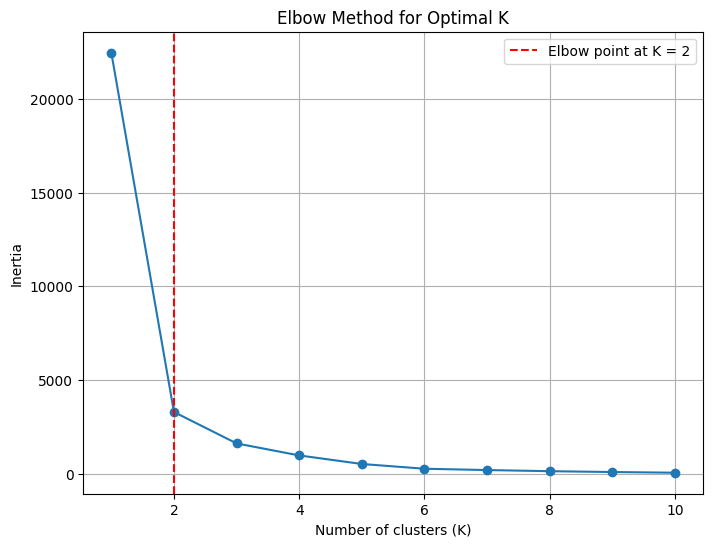

2


C:\Users\jiowe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [8]:
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt

# Assuming userDF is an existing dataframe
df = userDF.copy()

# Features for clustering
X = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumental', 'liveness', 'valence', 'tempo']]

# Choose how many clusters you want
if df.shape[0] < 4:
    number_clusters = df.shape[0]
else:
    # Calculate inertia for a range of K values
    number_clusters = (input("Number of cluster (input either int or optimal)"))
    
    if number_clusters == 'optimal':
        inertia = []
        K_range = range(1, min(11, df.shape[0]))  # Limiting K to a maximum of 10 or the number of samples
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=0)
            kmeans.fit(X)
            inertia.append(kmeans.inertia_)
        
        # Find the elbow point using KneeLocator
        knee_locator = KneeLocator(K_range, inertia, curve='convex', direction='decreasing')
        number_clusters = knee_locator.elbow
    else:
        number_clusters = int(number_clusters)


# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)

# Mark the elbow point
plt.axvline(x=number_clusters, color='red', linestyle='--', label=f'Elbow point at K = {number_clusters}')
plt.legend()

plt.show()



# Perform KMeans clustering
print(number_clusters)
kmeans = KMeans(n_clusters=number_clusters, random_state=0)
df['cluster'] = kmeans.fit_predict(X)

df.sort_values(by="cluster")

# Create new feature/column of artist_songName to remove duplicate later on
df["artist_songName"] = df["artist"] + "_" + df["songName"]

# Check for duplicates in user Playlist
df = df.drop_duplicates(subset=["artist_songName"], ignore_index=True)


### (4) Find top genre in each cluster

In [9]:
clusters = {}
topgenre_clusters = []
allgenres = []

# Output each cluster to a separate dataframe
for cluster_num in range(number_clusters):
    cluster_df = df[df['cluster'] == cluster_num].copy()  # Make a copy to avoid modifying the original dataframe
    clusters[cluster_num] = cluster_df

    common_genre = cluster_df['genre'].mode()[0]  # Find the most common genre in the cluster

    #newlist for top genres in each cluster
    topgenre_clusters.append(common_genre)
    allgenres = df['genre'].unique().tolist()

print("Top Genre's of User Playlist:" + str(topgenre_clusters))

Top Genre's of User Playlist:['country', 'hip hop']


### (5) Extract Both User and Dataset Csv

In [10]:
#Extract Database CSV
databaseDF = pd.read_csv("spotify_dataset_eda.csv", encoding="utf_8_sig")
databaseDF = databaseDF.drop(columns=['Unnamed: 0'])
#Selects columns that we want
databaseDF = databaseDF[["id","artist","songName", "genre","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumental","liveness",
        "valence","tempo",]]

#Create new feature/column of artist_songName
databaseDF["artist_songName"] = databaseDF["artist"] + "_" + databaseDF["songName"]

##Change all values to lowercase
databaseDF["artist_songName"] = databaseDF["artist_songName"].str.lower()

#Check for duplicates in database
databaseDF = databaseDF.drop_duplicates(subset=["artist_songName"],ignore_index= True)

ITERATE THROUGH ALL THE CLUSTERS FUCKU JAE

In [17]:

result = pd.DataFrame()  # Initialize finalrec as an empty DataFrame


for i in range(len(topgenre_clusters)):
    clusternumber = i
    genre = topgenre_clusters[i]
    #pullout existing user playlist clusters
    playlistDF = pd.DataFrame(clusters[clusternumber])

    #Selects columns that we want
    playlistDF = playlistDF[["id","artist","songName", "genre","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumental","liveness",
            "valence","tempo",]]


    # Get the column names of each DataFrame
    playlist_columns = set(playlistDF.columns)
    database_columns = set(databaseDF.columns)

    # Find columns in playlistDF that are not in databaseDF
    columns_in_playlist_not_in_database = playlist_columns - database_columns

    # Find columns in databaseDF that are not in playlistDF
    columns_in_database_not_in_playlist = database_columns - playlist_columns



    ## Merge user + dataset dataframe to normalise 
    #Normalise takes min and max in dataframe as reference and change it to 0 and 1 respectively
    #Group the dataframe as we gonna split it again alter
    databaseDF["type"] = "Dataset"
    playlistDF["type"] = "User"

    #Merge the 2 datasets together
    combinedDF = pd.concat([databaseDF,playlistDF], ignore_index=True)

    #Check for duplicates between user and Database
    combinedDF = combinedDF.drop_duplicates(subset=["artist_songName"], keep="last",ignore_index= True)

    ##Update databaseDF with removed songs from user Playlist
    databaseDF = combinedDF[(combinedDF["type"]== "Dataset")]

    ##Normalise and get Vectors for Dataset + User
    normalised_vector = get_features_database(combinedDF, feature_weight)

    ##Seperate User from databaseDF 
    database_vector = normalised_vector[normalised_vector["type"] == "Dataset"]
    user_vector = normalised_vector[normalised_vector["type"] == "User"]

    #Drop "type" column
    database_vector = database_vector.drop(columns="type")
    user_vector = user_vector.drop(columns="type")
    databaseDF = databaseDF.drop(columns=["type"])



    ##Single Vector Creation
    final_user_vector_list = []
    for i in user_vector.columns:
        final_user_vector_list.append(user_vector[i].sum()/len(user_vector[i]))

    #Putting into a vector dataframe
    final_user_vector = pd.DataFrame(columns=user_vector.columns,)
    final_user_vector.loc[0] = final_user_vector_list

    final_user_vector


    ##Recommendation Time!
    def generate_rec(databaseDF, database_vector, user_vector, genre, finalrec):
        # Cosine Similarity
        databaseDF["sim"] = cosine_similarity(database_vector, user_vector)

        # Drop rows with different genre from top 3 genres
        databaseDF = databaseDF[databaseDF["genre"].astype(str) == str(genre)]

        rec_top5 = databaseDF.sort_values('sim', ascending=False).head()
        number_append = 10//number_clusters
        rec_top5 = rec_top5.head(number_append);        
        num_rows = rec_top5.shape[0]

        rec_top5['cluster'] = clusternumber  # Assuming clusternumber is defined elsewhere
        df_concatenated = pd.concat([finalrec, rec_top5], ignore_index=True)
        return df_concatenated  # Return the concatenated DataFrame

    ##Get genre of particular cluster and run recommendation function
    genre = topgenre_clusters[clusternumber]
    ##Combine recommended songs from all 3 clusters
    final = generate_rec(databaseDF, database_vector, final_user_vector, genre, result) 
    
    # number_appended = 10//number_clusters
    # final = final.head(3)
    
    # result = pd.concat([result, final], ignore_index=True)

    result = final



result['id'] = result['id'].apply(lambda x: 'https://open.spotify.com/track/' + str(x))
# Convert the 'id' column to HTML hyperlinks
pd.set_option('display.max_colwidth', None)
result


,id,artist,songName,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumental,liveness,valence,tempo,artist_songName,sim,cluster
0,https://open.spotify.com/track/1WTWurcIy9hRnzJiJp3ZtI,Lainey Wilson,Weak-End,country,0.702,0.555,0,-7.396,1,0.0318,0.452,0.000003,0.1140,0.486,141.932,lainey wilson_weak-end,1.000000,0
1,https://open.spotify.com/track/1xt5FBy475sGBgWEfMtUCL,Jordan Davis,Detours,country,0.616,0.573,0,-6.668,1,0.0305,0.455,0.000000,0.1270,0.472,143.911,jordan davis_detours,0.998419,0
2,https://open.spotify.com/track/6SX9tFP04wH1sJytX7x7tL,Moe Bandy,Cowboys Ain't Supposed To Cry - 2012 Recording,country,0.668,0.513,0,-5.973,1,0.0261,0.590,0.000121,0.1480,0.494,133.128,moe bandy_cowboys ain't supposed to cry - 2012 recording,0.997887,0
3,https://open.spotify.com/track/1iS5HSAtnZkmuEsrg753Dq,Rejjie Snow,SUNNY CALIFORNIA,hip hop,0.510,0.563,11,-7.810,0,0.0601,0.155,0.000167,0.1350,0.367,149.868,rejjie snow_sunny california,0.988161,1
4,https://open.spotify.com/track/2UhmkV1lXMlRzmevvG8TRw,Gorillaz,Hong Kong,hip hop,0.513,0.582,11,-7.394,0,0.0285,0.712,0.036900,0.0771,0.241,148.128,gorillaz_hong kong,0.987284,1
5,https://open.spotify.com/track/1Eh2tS7tgwqvvQLIBbByHo,Luísa Sonza,Olhos Castanhos,hip hop,0.554,0.653,3,-5.090,0,0.0430,0.423,0.000000,0.1180,0.304,174.014,luísa sonza_olhos castanhos,0.987154,1
